In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import os
os.environ["MODIN_ENGINE"] = "ray"  # Modin will use Ray
from datetime import datetime as dt
import pandas_market_calendars as mcal
import dateutil

In [18]:
# get range of dates from the last 100 days
import datetime
numdays = 100
# get current date
base = datetime.datetime.today()
# list comp for current date - number of days for range of dates
date_list = [base - datetime.timedelta(days=x) for x in range(numdays)]
# put into dataframe to do datetime formatting
dates = pd.DataFrame(date_list, columns = ['dates'])
dates['dates'] = pd.to_datetime(dates.dates)
dates['dates'] = dates['dates'].dt.strftime('%Y-%m-%d')
# sort dates ascending values
dates = dates.sort_values(by="dates", ascending=True)
# all dates are in a list to use in REST API to fetch data
dates = list(dates['dates'])

In [21]:
ticker = 'X:ETHUSD'
range_agg = '/range/1/day/'
unadjusted = 'unadjusted=true'
sort = '&sort=asc'
limit = '&limit=50000'
POLYGON_URL = 'https://api.polygon.io/v2/aggs/ticker/'
from_date = '2013-12-06'
to_date = '2021-08-12'
POLYGON_API = '&apiKey=x6XqEaDjOWJXwVQRyBQ5kMEi8KlCYZqo'

In [22]:
datetime = []
open_price = []
high_price = []
low_price = []
close_price = []
volume = []
#for date in dates:
polygon = POLYGON_URL + ticker + range_agg + from_date + '/' + to_date + '?' + unadjusted + sort + limit + POLYGON_API
r_polygon = requests.get(polygon)
polygon_response = r_polygon.json()
for aggs in range(len(polygon_response['results'])):
    datetime.append(dt.fromtimestamp(polygon_response['results'][aggs]['t']/ 1000.0).strftime('%Y-%m-%d %H:%M:%S'))
    open_price.append(polygon_response['results'][aggs]['o'])
    high_price.append(polygon_response['results'][aggs]['h'])
    low_price.append(polygon_response['results'][aggs]['l'])
    close_price.append(polygon_response['results'][aggs]['c'])
    volume.append(polygon_response['results'][aggs]['v'])

In [23]:
df = pd.DataFrame(list(zip(datetime,open_price,high_price,low_price, close_price,volume)),
columns =['datetime', 'open', 'high', 'low', 'close', 'volume'])

In [24]:
df.head()

,datetime,open,high,low,close,volume
0,2017-01-01 00:00:00,8.16,8.60000,8.03,8.19000,138183.850802
1,2017-01-02 00:00:00,8.20,8.53000,8.05,8.38000,124362.400054
2,2017-01-03 00:00:00,8.38,10.09948,8.24,9.59000,454564.002304
3,2017-01-04 00:00:00,9.62,11.17000,9.34,11.16000,541714.004875
4,2017-01-05 00:00:00,11.13,11.80000,9.08,10.31859,727743.015608


In [25]:
len(df)

1685

In [26]:
df['datetime']

0       2017-01-01 00:00:00
1       2017-01-02 00:00:00
2       2017-01-03 00:00:00
3       2017-01-04 00:00:00
4       2017-01-05 00:00:00
               ...         
1680    2021-08-08 00:00:00
1681    2021-08-09 00:00:00
1682    2021-08-10 00:00:00
1683    2021-08-11 00:00:00
1684    2021-08-12 00:00:00
Name: datetime, Length: 1685, dtype: object

In [27]:
df.describe()

,open,high,low,close,volume
count,1685.000000,1685.000000,1685.000000,1685.000000,1.685000e+03
mean,538.975878,564.781316,508.881399,540.768092,6.666426e+05
std,693.847517,728.704550,653.785988,696.467934,4.940634e+05
min,8.160000,8.530000,0.100000,8.190000,3.274767e+04
25%,170.210000,177.940000,164.280000,170.890000,3.489217e+05
50%,264.700000,276.150000,249.530000,264.960000,5.438971e+05
75%,525.390000,548.810000,496.270000,525.550000,8.407192e+05
max,4179.770000,4384.430000,3760.000000,4179.760000,6.148473e+06


In [28]:
# Select only the important features i.e. the date and price
data = df[["datetime","close"]] # select Date and Price
# Rename the features: These names are NEEDED for the model fitting
data = data.rename(columns = {"datetime":"ds","close":"y"}) #renaming the columns of the dataset
data.tail(5)

,ds,y
1680,2021-08-08 00:00:00,3014.02
1681,2021-08-09 00:00:00,3162.34
1682,2021-08-10 00:00:00,3142.09
1683,2021-08-11 00:00:00,3163.30
1684,2021-08-12 00:00:00,3009.36


In [29]:
from prophet import Prophet
m = Prophet(daily_seasonality = True) # the Prophet class (model)
m.fit(data) # fit the model using all data

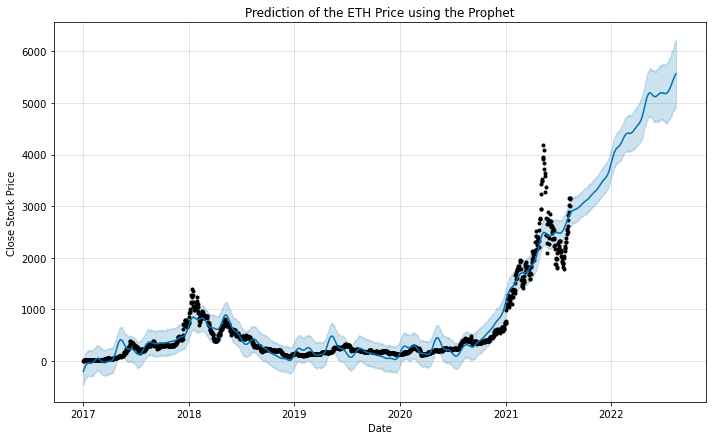

In [30]:
future = m.make_future_dataframe(periods=365) #we need to specify the number of days in future
prediction = m.predict(future)
m.plot(prediction)
plt.title("Prediction of the ETH Price using the Prophet")
plt.xlabel("Date")
plt.ylabel("Close Stock Price")
plt.show()

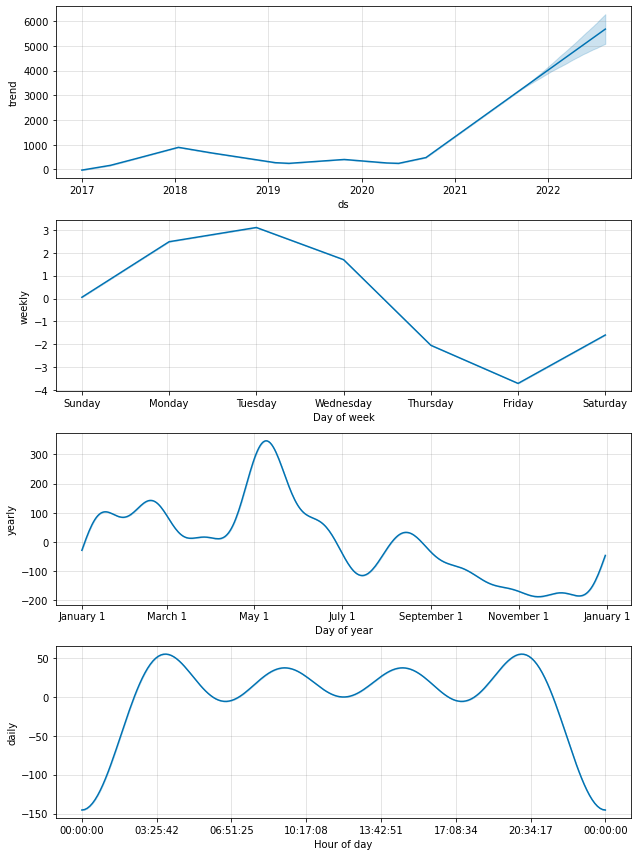

In [31]:
m.plot_components(prediction)
plt.show()

In [32]:
# try with some hyperparameter tuning
# Python
import itertools
import numpy as np
import pandas as pd
from prophet.diagnostics import cross_validation, performance_metrics

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(data)  # Fit model with given params
    df_cv = cross_validation(m, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 86 forecasts with cutoffs between 2018-01-15 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f158c104750>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 86 forecasts with cutoffs between 2018-01-15 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f157e96bf90>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 86 forecasts with cutoffs between 2018-01-15 00:00:00 and 2021-07-13 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f157e9f1690>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_se

    changepoint_prior_scale  seasonality_prior_scale        rmse
0                     0.001                     0.01  715.751493
1                     0.001                     0.10  732.103125
2                     0.001                     1.00  732.349391
3                     0.001                    10.00  732.001760
4                     0.010                     0.01  372.891943
5                     0.010                     0.10  375.997309
6                     0.010                     1.00  378.694174
7                     0.010                    10.00  374.934352
8                     0.100                     0.01  303.915163
9                     0.100                     0.10  304.862567
10                    0.100                     1.00  310.074454
11                    0.100                    10.00  305.935913
12                    0.500                     0.01  305.880295
13                    0.500                     0.10  315.730529
14                    0.5

In [33]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01}


In [34]:
m = Prophet(daily_seasonality = True, changepoint_prior_scale=0.1, seasonality_prior_scale=0.01) # the Prophet class (model)
m.fit(data)

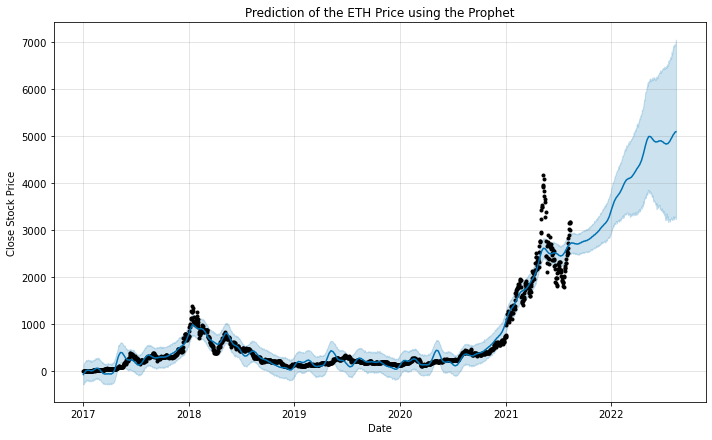

In [35]:
future = m.make_future_dataframe(periods=365) #we need to specify the number of days in future
prediction = m.predict(future)
m.plot(prediction)
plt.title("Prediction of the ETH Price using the Prophet")
plt.xlabel("Date")
plt.ylabel("Close Stock Price")
plt.show()

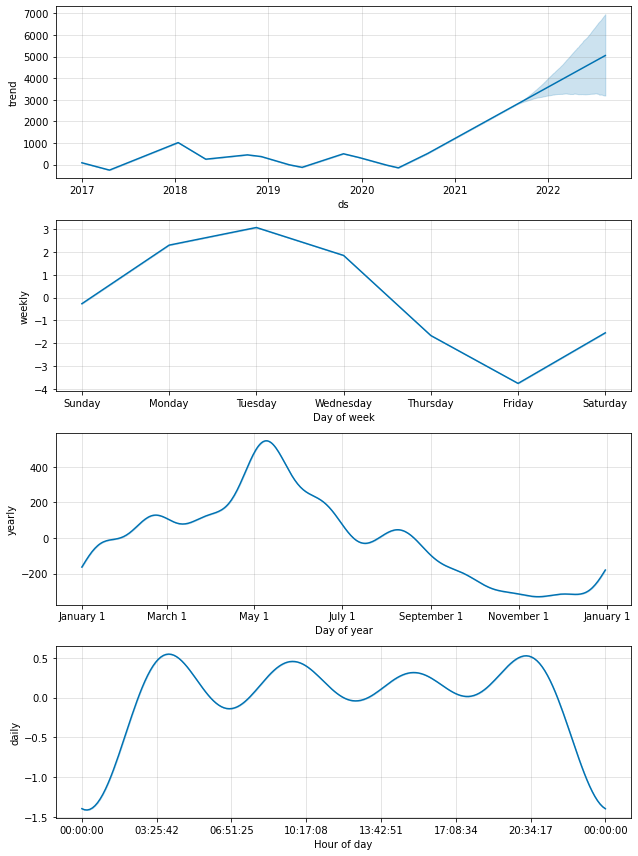

In [36]:
m.plot_components(prediction)
plt.show()